In [91]:
import torch
import random
import numpy as np
from transformers import pipeline
from PIL import Image
from diffusers import StableDiffusionControlNetImg2ImgPipeline, StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import make_image_grid

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [92]:
test_img = Image.open('test_images/original/t1.jpg')
captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")
txt = captioner(test_img)[0]['generated_text']



Device set to use cuda:0


In [93]:
art_method = random.choice(['Oil Painting', 'Watercolor', 'Digital Painting', 'Crayon Painting'])
art_details = random.choice(['Soft brushstrokes', 'intricate textures', 'subtle atmospheric perspective'])
domain_description = {
    "art_painting": f"{art_method}, {art_details}",
    "cartoon": "thick outlines, vivid colors, simple shapes, Disney-like style, playful atmosphere, flat 2D perspective",
    "sketch": "{pencil sketch}, {line art}, simple black-and-white sketch style, minimal shading",
    "photo": "realistic lighting, camera-like details, natural, Detailed skin texture, neutral color grading"
}

In [105]:
prefix = "convert the image into a high quality and detailed image in"
category = "dog"
description = domain_description["sketch"]
prompt_new = f"{description}, {category}"
print(prompt_new)

{pencil sketch}, {line art}, simple black-and-white sketch style, minimal shading, dog


In [106]:
negative_prompt = '''lowres, bad anatomy, bad hands, text,error, missing fngers,extra digt ,fewer digits,cropped, wort quality ,low quality,normal quality, jpeg artifacts,signature,watermark, username, blurry, bad feet,'''
preventing_categories = "art_painting, photo, cartoon"

negative_prompt = negative_prompt + preventing_categories

In [96]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", use_safetensors=True)

# img2img pipeline
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    # "stable-diffusion-v1-5/stable-diffusion-v1-5", 
    "SimianLuo/LCM_Dreamshaper_v7",
    controlnet=controlnet, 
    torch_dtype=torch.float32,
    use_safetensors=True,
    safety_checker = None,
    requires_safety_checker = False
).to("cuda")

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 13.14it/s]


In [97]:
def get_depth_map(image, depth_estimator):
    image = depth_estimator(image)["depth"]
    image = np.array(image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    detected_map = torch.from_numpy(image).float() / 255.0
    depth_map = detected_map.permute(2, 0, 1)
    return depth_map

depth_estimator = pipeline("depth-estimation")
depth_map = get_depth_map(test_img, depth_estimator).to(torch.float16).unsqueeze(0).to("cuda")

No model was supplied, defaulted to Intel/dpt-large and revision bc15f29 (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


In [98]:
# def get_depth_map(image,depth_estimator):
#     image = depth_estimator(image)["depth"]
#     image = np.array(image)
#     image = image[:, :, None]
#     image = np.concatenate([image, image, image], axis=2)
#     detected_map = torch.from_numpy(image).float() / 255.0
#     depth_map = detected_map.permute(2, 0, 1)
#     depth_map = Image.fromarray(image)
#     return depth_map
# depth_estimator = pipeline("depth-estimation")
# depth_map = get_depth_map(test_img, depth_estimator)

100%|██████████| 24/24 [00:38<00:00,  1.59s/it]


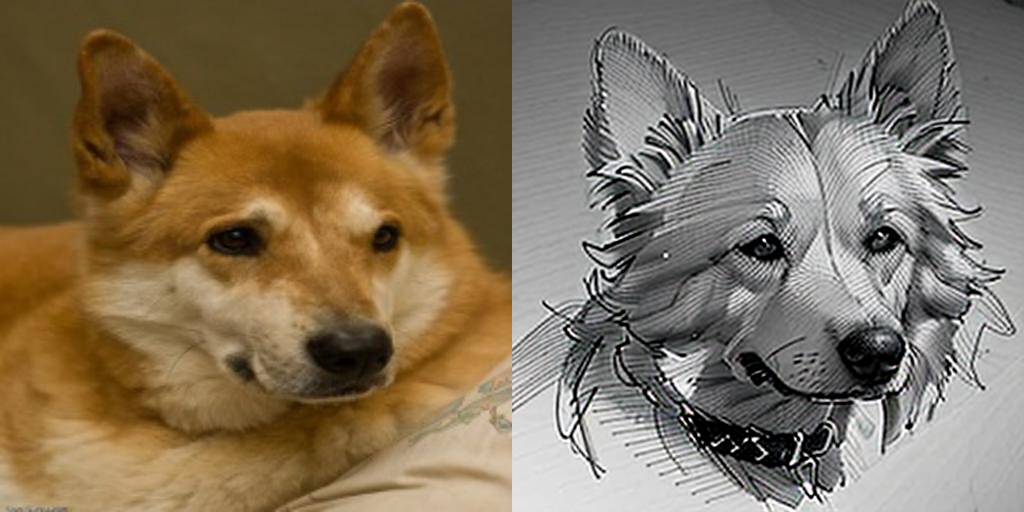

In [107]:
output = pipe(
    prompt_new, 
    image=test_img,
    control_image=depth_map, 
    # negative_prompt=negative_prompt,
    num_inference_steps=30,
    # guidance_scale=6.0,      # CFG scale
    # strength=0.7,            # denoising strength
).images[0]
make_image_grid([test_img, output], rows=1, cols=2)

In [100]:
def combine_images(original_img, augmented_img, blend_width=20):
        width, height = original_img.size
        combine_choice = random.choice(['horizontal', 'vertical'])

        if combine_choice == 'vertical':  # Vertical combination
            mask = np.linspace(0, 1, blend_width).reshape(-1, 1)
            mask = np.tile(mask, (1, width))  # Extend mask horizontally
            mask = np.vstack([np.zeros((height // 2 - blend_width // 2, width)), mask,
                              np.ones((height // 2 - blend_width // 2 + blend_width % 2, width))])
            mask = np.tile(mask[:, :, np.newaxis], (1, 1, 3))

        else:
            mask = np.linspace(0, 1, blend_width).reshape(1, -1)
            mask = np.tile(mask, (height, 1))  # Extend mask vertically
            mask = np.hstack([np.zeros((height, width // 2 - blend_width // 2)), mask,
                              np.ones((height, width // 2 - blend_width // 2 + blend_width % 2))])
            mask = np.tile(mask[:, :, np.newaxis], (1, 1, 3))

        original_array = np.array(original_img, dtype=np.float32) / 255.0
        augmented_array = np.array(augmented_img, dtype=np.float32) / 255.0

        blended_array = (1 - mask) * original_array + mask * augmented_array
        blended_array = np.clip(blended_array * 255, 0, 255).astype(np.uint8)

        blended_img = Image.fromarray(blended_array)
        return blended_img

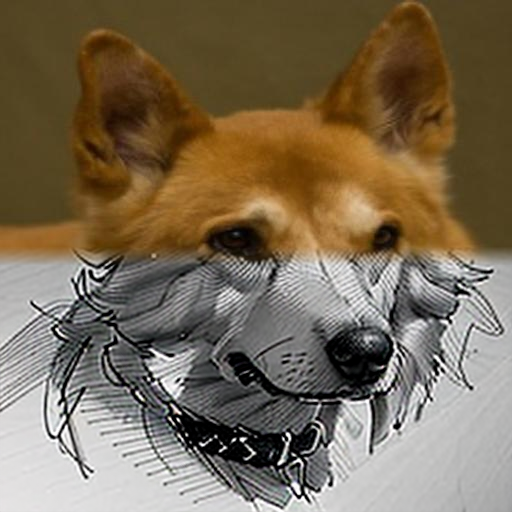

In [110]:
combine_images(test_img, output)